# Quantum Cloud, Near-Time Compute, and Qiskit Runtime
<br>
<br>

jessieyu@us.ibm.com

You can find a copy of this presentation at

https://github.com/Qiskit-Partners/qiskit-runtime/tree/main/tutorials/ieee_workshop.ipynb

## Agenda

- Introduction to Qiskit
- Introduction to IBM Quantum
- Variational Quantum Algorithms
- What is Qiskit Runtime
- Running a Qiskit Runtime program
- Uploading a Qiskit Runtime program
- Invoking Qiskit Runtime API directly
- Exercise

## Introduction to Qiskit

Qiskit is a Python-based, open source software development toolkit (SDK) for working with quantum computers.  It can be used at the level of circuits, algorithms, and application modules.


### Installing Qiskit

*Command:* `pip install Qiskit`

*Python version:* 3.6+


### Typical Qiskit Workflow

**Build**: Design a quantum circuit(s) that represents the problem you are considering.

**Compile**: Compile circuits for a specific quantum backend, e.g., a quantum system or classical simulator.

**Run**: Run the compiled circuits on the specified quantum backend.

**Analyze**: Compute summary statistics and visualize the results of the experiments.


#### Step 1: Build the Circuit

In [1]:
from qiskit import QuantumCircuit

# Create a quantum circuit with 2 qubits and 2 classical bits
circuit = QuantumCircuit(2, 2)

# Add a Hadamard gate on qubit 0
circuit.h(0)

# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuit.cx(0, 1)

# Measure qubits 0 and 1 onto classical bits 0 and 1
circuit.measure([0, 1], [0, 1])

# Draw the circuit
circuit.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

#### Step 2: Compile the Circuit

In [2]:
from qiskit import transpile
from qiskit.providers.aer import AerSimulator

# Use a local simulator
simulator = AerSimulator()

# Compile the circuit down to low-level instructions supported by the backend
compiled_circuit = transpile(circuit, simulator)


#### Step 3: Run the Circuit

In [3]:
# Execute the circuit on the qasm simulator
# shots defines the number of executions
job = simulator.run(compiled_circuit, shots=1000)

# Grab results from the job
result = job.result()


#### Step 4: Analyze and Visualize the Result

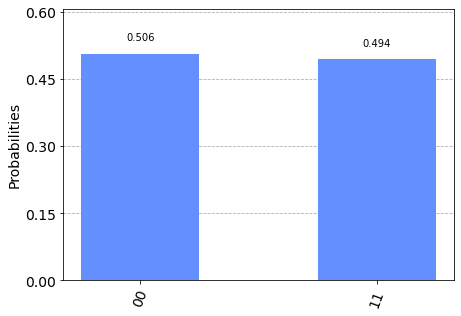

In [4]:
from qiskit.visualization import plot_histogram

# Get summarized counts of qubit measurements
counts = result.get_counts()

# Plot a histogram
# "00" means both qubits were measured 0; "11" means both were measured 1.
plot_histogram(counts)

## Introduction to IBM Quantum

Offers access to cloud-based quantum computing services

- quantum processors
- simulators
- experiments
- tutorials
- **runtime**

### Using Qiskit to access IBM Quantum services

Qiskit is designed to work with different providers. A _provider_ is any entity that provides quantum-related services that can be accessed using Qiskit. The most common service is quantum processors. `AQT`, `Honeywell`, and `IBM` are example of companies that provide access to their quantum processors through Qiskit.

Since `Runtime` is currently an IBM-only service, this tutorial will focus on using IBM Quantum services.


Before you can access IBM Quantum services, you need an IBM Quantum account. 
You can sign up for an account at https://quantum-computing.ibm.com/.

Once you have an account, you can grab your API token

<img src="images/api_token.png">

#### Initializing Your Account in Qiskit

In [5]:
# Import the module needed to access IBM Quantum
from qiskit import IBMQ

# Load your IBM Quantum account or enable the account if it's not previously saved.
provider   = IBMQ.load_account()
# provider = IBMQ.enable_account(MY_TOKEN)

IBM Quantum provider uses the syntax:

```
provider.SERVICE.METHOD()
```

where SERVICE might be one of {backend, runtime, etc}

- Use `provider.backend` to target a quantum processor or simulator for running circuits
- Use `provider.runtime` to target a higher level runtime program

 

#### Running a Circuit on IBM Quantum Backend

In [6]:
# Select a backend to run the circuit
backend = provider.backend.ibmq_qasm_simulator

# Compile the circuit for this backend
compiled_circuit = transpile(circuit, backend)

# Run the circuit on the backend
job = backend.run(compiled_circuit)

# Get the result
result = job.result()

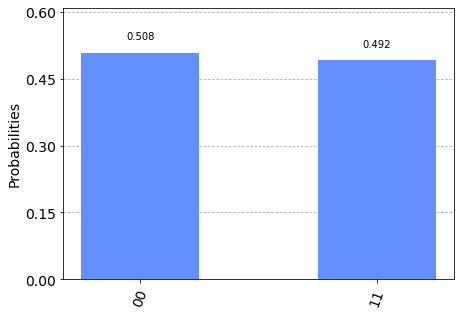

In [7]:
# Plot the result
# "00" means both qubits were measured 0; "11" means both were measured 1.
plot_histogram(result.get_counts())


## Variational Quantum Algorithms

Variational Quantum Algorithms (VQA) use a classical optimizer to train a parameterized quantum circuit to approximate solutions for a given problem. 

VQA's typically need fewer gates and qubits. In turn, they are more resistant to noise.

Therefore, they are well suited to handle near-term quantum computer constraints.

VQA's are typically iterative. Each iteration involves both quantum and classical processing. 

Output (a measurement) from one iteration is sent to the classical optimizer which generates input (a parameter) for the next iteration:

<div>
<img src="images/qva_loop.png" width="600" align="left"/>
</div>

## Running a VQA Prior to the Qiskit Runtime

<img src="images/vqa_pre_runtime.png">

## Qiskit Runtime

Qiskit Runtime is a new execution model. 

It reduces I/O overhead for applications, such as VQA's, that need many iterations that use both quantum and classical processing. 



<img src="images/vqa_with_runtime.png">

### Qiskit Runtime Benefits

This year, the Qiskit Runtime contributed to a **120x** speedup in simulating lithium hydride when compared to a previous simulation from in 2017.

Beyond performance, you can also create larger applications using smaller, pre-built programs.

Qiskit Runtime programs can be commercialized or shared freely in the cloud.

### Defining a Qiskit Runtime Program


**source**: Python code that uses Qiskit to do quantum/classical processing

**metadata**: Documentation that describes what the program does

#### Example: sample-program

In [8]:
import random

from qiskit import transpile
from qiskit.circuit.random import random_circuit

def prepare_circuits(backend):
    """Generate a random circuit."""
    circuit = random_circuit(num_qubits=5, depth=4, measure=True,
                             seed=random.randint(0, 1000))
    return transpile(circuit, backend)


def main(backend, user_messenger, iterations):
    """Main entry point of the program."""
    for it in range(iterations):
        qc = prepare_circuits(backend)
        result = backend.run(qc).result()
        user_messenger.publish({"iteration": it, "counts": result.get_counts()})

    return "All done!"

#### sample-program Metadata

```
{
  "name": "sample-program",
  "description": "A sample runtime program.",
  "max_execution_time": 300,
  "version": "1.0",
  "backend_requirements": {"min_num_qubits":  5},
  "parameters": [
    {"name": "iterations", "description": "Number of iterations to run. Each iteration generates and runs a random circuit.", "type": "int", "required": True}
  ],
  "return_values": [
    {"name": "-", "description": "A string that says 'All done!'.", "type": "string"}
  ],
  "interim_results": [
    {"name": "iteration", "description": "Iteration number.", "type": "int"},
    {"name": "counts", "description": "Histogram data of the circuit result.", "type": "dict"}
  ]
}
```

## Finding and Running Programs

Since programs are now stored in the cloud, you can browse and run previously published programs.

Using Qiskit (0.29+), you can search by program ID or browse the entire catalog. 

You can also list available programs on the IBM Quantum website. 

### Finding by Program ID

In [9]:
# Print the metadata of a runtime program
print(provider.runtime.program("sample-program"))

sample-program:
  Name: sample-program
  Description: A sample runtime program.
  Version: 1.0
  Creation date: 2021-07-02T13:45:13.000000
  Max execution time: 300
  Input parameters:
    - iterations:
      Description: Number of iterations to run. Each iteration generates and runs a random circuit.
      Type: int
      Required: True
  Interim results:
    - iteration:
      Description: Iteration number.
      Type: int
    - counts:
      Description: Histogram data of the circuit result.
      Type: dict
  Returns:
    - -:
      Description: A string that says 'All done!'.
      Type: string


### Listing All Programs

In [10]:
provider.runtime.pprint_programs(refresh=True)

vqe:
  Name: vqe
  Description: Variational Quantum Eigensolver (VQE) to find the minimal eigenvalue of a Hamiltonian.
  Version: 1.1
  Creation date: 2021-08-12T07:06:50.000000
  Max execution time: 18000
  Input parameters:
    - ansatz:
      Description: A parameterized quantum circuit preparing the ansatz wavefunction for the VQE. It is assumed that all qubits are initially in the 0 state.
      Type: QuantumCircuit
      Required: True
    - operator:
      Description: The Hamiltonian whose smallest eigenvalue we're trying to find.
      Type: PauliSumOp
      Required: True
    - optimizer:
      Description: The classical optimizer used in to update the parameters in each iteration. Can be either any of Qiskit's optimizer classes. If a dictionary, only SPSA and QN-SPSA are supported and the dictionary must specify the name and options of the optimizer, e.g. ``{'name': 'SPSA', 'maxiter': 100}``.
      Type: Union[Optimizer, dict]
      Required: True
    - initial_parameters:
 

### Using the IBM Quantum Website

<img src="images/ibmq_services.png">

<img src="images/runtime_programs.png">

<img src="images/sample_program.png">

### Running a Program 

Step 1 of 2: defining inputs, options, and callback

In [11]:
# Define program inputs in a dictionary
runtime_inputs = {
    'iterations': 2
}

In [12]:
# Alternatively, define program inputs in a namespace
params = provider.runtime.program("sample-program").parameters()
params.iterations = 2

In [13]:
# Define program options (more on backend selection later...)
options = {'backend_name': 'ibmq_qasm_simulator'}

In [14]:
# Define interim result callback (optional)
def interim_result_callback(job_id, interim_result):
    print(f"interim result: {interim_result}")

### Running a Program 

Step 2 of 2: executing and getting results

In [15]:
# Run program
job = provider.runtime.run(program_id="sample-program",
                           options=options,
                           inputs=runtime_inputs,
                           callback=interim_result_callback
                          )
print(job.job_id())

c4t0trbk1sj3cl16qsag


In [16]:
# Get job result
result = job.result()
print(result)

interim result: {'iteration': 0, 'counts': {'01110': 41, '01000': 39, '00010': 36, '00100': 32, '00110': 41, '00111': 90, '00011': 87, '00000': 28, '01010': 33, '01111': 101, '01001': 87, '00101': 108, '01100': 32, '01101': 95, '01011': 83, '00001': 91}}
interim result: {'iteration': 1, 'counts': {'11111': 7, '01111': 19, '01010': 178, '11010': 162, '11001': 249, '01001': 229, '11000': 79, '01000': 101}}
All done!


### Backend Selection

At this time, Qiskit Runtime is only available on `ibmq_qasm_simulator` for open-access users. It is available on select backends for premium users. 

In [17]:
premium_provider = IBMQ.get_provider(project='terra')

# Use input_allowed="runtime" to select backends that support runtime
premium_provider.backends(input_allowed='runtime')

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-internal', group='dev-qiskit', project='terra')>,
 <IBMQBackend('ibmq_casablanca') from IBMQ(hub='ibm-q-internal', group='dev-qiskit', project='terra')>]

## Job Interaction


When you run a published program, the execution instance becomes a job. 

Using Qiskit, you can reference and interact with your job.

You can also list and interact with your jobs on the IBM Quantum website. 


Note that a **runtime job** is an instance of `qiskit.providers.ibmq.runtime.RuntimeJob`. It is not the same as a traditional circuit job and therefore has different methods/attributes.


Runtime job restrictions:

- Cannot exceed max execution time
- Consumes "fair share"
- 35GB of memory per execution

### Referencing Jobs

In [18]:
retrieved_job = provider.runtime.job(job.job_id())
print(f"Job {retrieved_job.job_id()} is an execution instance of runtime program {retrieved_job.program_id}.")
print(f"This job ran on backend {retrieved_job.backend()} and had input parameters {retrieved_job.inputs}")

Job c4t0trbk1sj3cl16qsag is an execution instance of runtime program sample-program.
This job ran on backend ibmq_qasm_simulator and had input parameters {'iterations': 2}


In [19]:
retrieved_jobs = provider.runtime.jobs(limit=2)
for rjob in retrieved_jobs:
    print(rjob.job_id())

c4t0trbk1sj3cl16qsag
c4t0tbjk1sj3cl16qs60


### Summary of job operations

- `job_id()`, `backend()`, `inputs`, `program_id`, `creation_date`: metadata of job execution
<br>

- `result()`, `error_messages()`, `logs()`, `status()`: returns job execution output and status
<br>

- `stream_results`, `cancel_result_streaming()`: (re)enables and disable streaming interim results
<br>

- `cancel()`: cancels the job

Or you can use the IBM Quantum website:

<img src="images/program_jobs.png">

## Writing, Uploading, and Testing a Qiskit Runtime Program

Like the example we saw earlier, we will now write a new program and upload it to the cloud. 

We will write the metadata and source code. We will then test it after upload and show the optional step of making the program publicly available.
<br>


**Note**: Only select accounts can upload runtime programs presently. A future release will support all accounts.

### Defining Program Metadata

In [20]:
metadata = {
  "name": "ieee-workshop",
  "description": "Exploring the equator of a Bloch sphere using input RZ angles and returning the x measurements.",
  "max_execution_time": 300,
  "version": "1.0",
  "parameters": [
    {"name": "angles", "description": "A list of angles to rotate around the z axis.", "type": "numpy array or list", "required": True}
  ],
  "return_values": [
    {"name": "-", "description": "Combined measurements.", "type": "list"}
  ],
  "interim_results": [
    {"name": "angle", "description": "Angle used for the rotation.", "type": "float"},
    {"name": "counts", "description": "Histogram data of the circuit result.", "type": "dict"}
  ]
}


### Writing Source Code

Step 1: Prepare the circuit

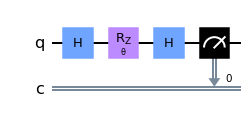

In [21]:
from qiskit.circuit import QuantumCircuit, Parameter

def prepare_circuits():
    theta = Parameter('θ')
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.rz(theta, 0)
    qc.h(0)
    qc.measure(0, 0)
    return qc

    
circ = prepare_circuits()
circ.draw('mpl')

### Writing Source Code

Step 2: Write the main function

<img src="images/main_function.png">

In [22]:
from qiskit import transpile

def main(backend, user_messenger, angles):
    all_counts = []
    
    # Get the parameterized circuit
    circ = prepare_circuit()
    
    # Get the parameter variable
    param = circ.parameters[0]

    # For each input angle
    for theta_val in angles:
        # Set the parameter value
        bound_circ = circ.bind_parameters({param: theta_val})
        # Run the circuit
        job = backend.run(transpile(bound_circ, backend=backend))
        # Get counts
        counts = job.result().get_counts()
        # Publish interim result
        user_messenger.publish({"angle": theta_val, "counts": counts})
        # Aggregate counts
        all_counts.append(counts)
    
    # Return combined measurements
    return all_counts

Note that the `backend` here is an instance of `qiskit.providers.ibmq.runtime.ProgramBackend`, **not** an `IBMQBackend` and does not have the same methods. You cannot, for example, use this backend to retrieve previously executed jobs.

### Uploading Your Program

In [23]:
runtime_program = """
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import transpile

def prepare_circuits():
    theta = Parameter('θ')
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.rz(theta, 0)
    qc.h(0)
    qc.measure(0, 0)
    return qc

def main(backend, user_messenger, angles):
    circ = prepare_circuits()
    param = circ.parameters[0]
    all_counts = []
    for theta_val in angles:
        bound_circ = circ.bind_parameters({param: theta_val})
        job = backend.run(transpile(bound_circ, backend=backend))
        counts = job.result().get_counts()
        user_messenger.publish({"angle": theta_val, "counts": counts})
        all_counts.append(counts)
    return all_counts    
"""

In [24]:
program_id = provider.runtime.upload_program(
    name="ieee-workshop",
    data=runtime_program.encode(),
    metadata=metadata
)
print(program_id)

ieee-workshop


In [25]:
# Alternatively, you can choose files

# program_id = provider.runtime.upload_program(
#     name="ieee-workshop"
#     data="ieee_workshop.py"
#     metadata="ieee_workshop.json"
# )

In [26]:
# Let's make sure the program was uploaded properly.

print(provider.runtime.program(program_id))

ieee-workshop:
  Name: ieee-workshop
  Description: Exploring the equator of a Bloch sphere using input RZ angles and returning the x measurements.
  Version: 1.0
  Creation date: 2021-09-09T13:41:12.000000
  Max execution time: 300
  Input parameters:
    - angles:
      Description: A list of angles to rotate around the z axis.
      Type: numpy array or list
      Required: True
  Interim results:
    - angle:
      Description: Angle used for the rotation.
      Type: float
    - counts:
      Description: Histogram data of the circuit result.
      Type: dict
  Returns:
    - -:
      Description: Combined measurements.
      Type: list


### Testing Your Program

You can test your program using a local simulator or a real backend. It is faster to test the program locally, but it requires a slightly different test case variant because the cloud service handles serialization automatically. 

Once uploaded, you can test your program using Qiskit or the IBM Quantum website. 

We will focus on cloud testing using Qiskit here.



#### Testing Uploaded Program Using Qiskit

In [27]:
import numpy as np

# Define interim result callback
def interim_result_callback(job_id, interim_result):
    print(f"interim result: {interim_result}")
    
# Define program inputs
theta_range = np.linspace(0, 2 * np.pi, 12)
runtime_inputs = {"angles": theta_range}

# Define options
options = {'backend_name': 'ibmq_qasm_simulator'}

# Run program
job = provider.runtime.run(program_id="ieee-workshop",
                           options=options,
                           inputs=runtime_inputs,
                           callback=interim_result_callback
                          )
print(job.job_id())
final_result = job.result()

c4t0tu24nm9h1e1cchd0
interim result: {'angle': 0.0, 'counts': {'0': 1024}}
interim result: {'angle': 0.5711986642890533, 'counts': {'1': 72, '0': 952}}
interim result: {'angle': 1.1423973285781066, 'counts': {'0': 714, '1': 310}}
interim result: {'angle': 1.7135959928671598, 'counts': {'0': 441, '1': 583}}
interim result: {'angle': 2.284794657156213, 'counts': {'1': 851, '0': 173}}
interim result: {'angle': 2.8559933214452666, 'counts': {'0': 23, '1': 1001}}
interim result: {'angle': 3.4271919857343196, 'counts': {'0': 27, '1': 997}}
interim result: {'angle': 3.998390650023373, 'counts': {'0': 169, '1': 855}}
interim result: {'angle': 4.569589314312426, 'counts': {'0': 449, '1': 575}}
interim result: {'angle': 5.140787978601479, 'counts': {'1': 293, '0': 731}}
interim result: {'angle': 5.711986642890533, 'counts': {'1': 79, '0': 945}}
interim result: {'angle': 6.283185307179586, 'counts': {'0': 1024}}


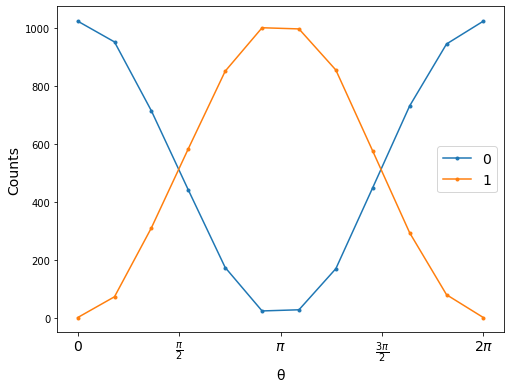

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), final_result)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), final_result)), '.-', label='1')

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

#### Making the Program Public (Optional)

In [29]:
# Make the program public now that we know it's working
provider.runtime.set_program_visibility(program_id=program_id, public=True)

#### Deleting the Program (Optional)

In [30]:
# Delete the program
provider.runtime.delete_program("ieee-workshop")

## Invoking Qiskit Runtime API directly

You can communicate with the Qiskit Runtime API directly using basic HTTP requests without Qiskit. This can be useful, for example, if you want to integrate your non-Python application with Qiskit Runtime.

Qiskit Runtime API documentation can be found here: https://runtime-us-east.quantum-computing.ibm.com/openapi/

<img src="images/runtime_api.png">

### Authenticating with the Service

In [31]:
# You'll need to pass your API token in the header of every call

import os
import requests
import json

api_token = os.environ.get("QE_TOKEN")

headers = {
  'Authorization': f'Bearer {api_token}',
  'Content-Type': 'application/json'
}

RUNTIME_API_URL = "https://runtime-us-east.quantum-computing.ibm.com/"

### Listing Programs

In [32]:
response = requests.get(RUNTIME_API_URL + 'programs' , headers=headers)

if response.status_code != 200:
    raise ValueError(f"Unexpected status code: {response.status_code}")

list_of_programs = response.json()    
print(f'Qiskit Runtime Programs:')

for program in list_of_programs:
    print(f'- {program["name"]}: {program["description"]} ')

Qiskit Runtime Programs:
- vqe: Variational Quantum Eigensolver (VQE) to find the minimal eigenvalue of a Hamiltonian. 
- circuit-runner: A runtime program that takes one or more circuits, compiles them, executes them, and optionally applies measurement error mitigation. 
- sample-program: A sample runtime program. 
- quantum-kernel-alignment: Quantum kernel alignment algorithm that learns, on a given dataset, a quantum kernel maximizing the SVM classification margin. 


### Running sample-program

In [33]:
# Prepare program input
runtime_inputs = {"iterations": 2}

# Prepare request parameters
params = json.dumps({
  "programId": "sample-program",
  "hub": "ibm-q",
  "group": "open",
  "project": "main",
  "backend": "ibmq_qasm_simulator",
  "params": [
    json.dumps(runtime_inputs)
  ]
})

# Send the request
response = requests.post(RUNTIME_API_URL + 'jobs', data=params, headers=headers)

if response.status_code != 200:
    raise ValueError(f"Unexpected status code: {response.status_code}")

job_id =  response.json()['id']
print(f"Job: {job_id}")

Job: c4t0tvjk1sj3cl16qsf0


In [34]:
# You are going to get a 204 status code while the Qiskit program is still running.

import time

while True:
    response = requests.get(RUNTIME_API_URL + 'jobs/'+ job_id +'/results', headers=headers)

    if response.status_code == 200:
        print(f'Final Result: {response.text}')
        break
        
    elif response.status_code == 204:
        print(f'Waiting for the final result')
        time.sleep(3)
        
    else:
        print(f'Error:{response.status_code}')
        break

Waiting for the final result
Waiting for the final result
Final Result: All done!


## Exercise: Running sample-program

In [ ]:
from qiskit import IBMQ

provider = IBMQ.load_account()

program_inputs = {'iterations': 2}
options = {'backend_name': "ibmq_qasm_simulator"}

job = provider.runtime.run(program_id="sample-program",
                           options=options,
                           inputs=program_inputs,
                          )
print(f"job id: {job.job_id()}")
print(f"\nFinal result: {job.result()}")

To sign up for an IBM Quantum account: https://quantum-computing.ibm.com/.